## Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **movies**. Before that, I'll also pass in column names for each CSV and read them using pandas (the column names are available in the [Readme](https://github.com/khanhnamle1994/movielens/blob/master/README.md) file).

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('zomato.csv', encoding='latin-1')
ratings = ratings.dropna() 
  
# To reset the indices  
ratings = ratings.reset_index(drop = True) 



In [199]:
ratings.to_csv ('zomato_cleaned.csv', header=True)


In [217]:
ratings = pd.read_csv('zomato_cleaned.csv', encoding='latin-1')

Now lets take a peak into the content of each file to understand them better.

### Ratings Dataset

In [200]:
# Check the top 5 rows
print(ratings.head())

                                                 url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5  

In [169]:
# Check the file info
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23193 entries, 0 to 23192
Data columns (total 17 columns):
url                            23193 non-null object
address                        23193 non-null object
name                           23193 non-null object
online_order                   23193 non-null object
book_table                     23193 non-null object
rate                           23193 non-null object
votes                          23193 non-null int64
phone                          23193 non-null object
location                       23193 non-null object
rest_type                      23193 non-null object
dish_liked                     23193 non-null object
cuisines                       23193 non-null object
approx_cost(for two people)    23193 non-null object
reviews_list                   23193 non-null object
menu_item                      23193 non-null object
listed_in(type)                23193 non-null object
listed_in(city)                23193 non-nul

### Cuisines
The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [170]:
# Make a census of the genre keywords
genre_labels = set()
for s in ratings['cuisines'].str.split(',').values:
    try:
        genre_labels = genre_labels.union(set(s))
    except:
        continue

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split(','):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(ratings, 'cuisines', genre_labels)
keyword_occurences[:5]

[[' Chinese', 6025],
 ['North Indian', 5424],
 [' North Indian', 4596],
 [' Continental', 2863],
 ['Cafe', 2788]]

The top 5 genres are, in that respect order: Drama, Comedy, Action, Thriller, and Romance. I'll show this on a wordcloud too in order to make it more visually appealing.

In [171]:
!pip install wordcloud

You should consider upgrading via the 'c:\users\mehak\appdata\local\programs\python\python36\python.exe -m pip install --upgrade pip' command.


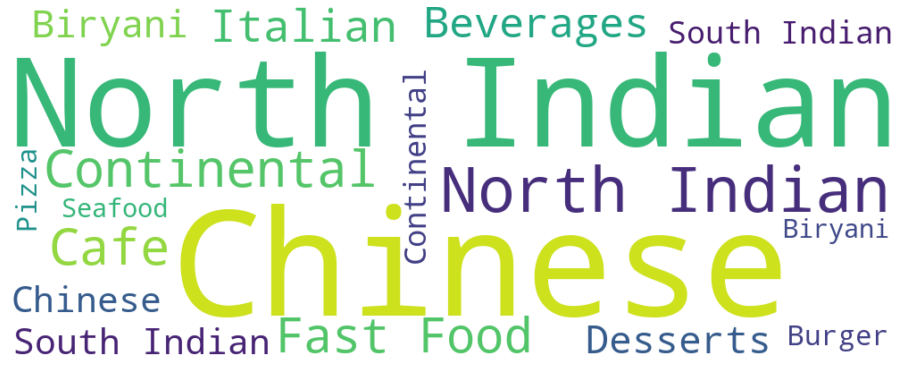

In [172]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('wordcloud.png')

## Types of Recommendation Engines

### 1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

## Content-Based Recommendation Model
### Theory
The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “**the results of latest European Socccer games**” on Google. It is certain that “**the**” will occur more frequently than “**soccer games**” but the relative importance of **soccer games** is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Below is the equation to calculate the TF-IDF score:
![tfidf](images/tfidf.jpg)

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the **Vector Space Model** which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an **n-dimensional space** and the angles between the vectors are calculated to **determine the similarity between the vectors**. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.

![vector-space](images/vector_space.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the **value of cosine will increase with decreasing value of the angle** between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

### Implementation
With all that theory in mind, I am going to build a Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre. To do so, I will make use of the file **movies.csv**.

In [218]:
ratings['cuisines'] = ratings['cuisines'].str.split(',')
#print(ratings['cuisines'])

In [220]:
# Break up the big genre string into a string array

# Convert genres to string value
ratings['cuisines_updated'] = ratings['cuisines'].fillna("").astype('str')
print(ratings['cuisines_updated'])

0                 ['North Indian', ' Mughlai', ' Chinese']
1                    ['Chinese', ' North Indian', ' Thai']
2                         ['Cafe', ' Mexican', ' Italian']
3                        ['South Indian', ' North Indian']
4                          ['North Indian', ' Rajasthani']
5                                         ['North Indian']
6                           ['Pizza', ' Cafe', ' Italian']
7                     ['Cafe', ' Italian', ' Continental']
8        ['Cafe', ' Mexican', ' Italian', ' Momos', ' B...
9                                                 ['Cafe']
10                    ['Cafe', ' Italian', ' Continental']
11        ['Cafe', ' Chinese', ' Continental', ' Italian']
12                                ['Cafe', ' Continental']
13                        ['Cafe', ' Mexican', ' Italian']
14                                                ['Cafe']
15       ['Cafe', ' Fast Food', ' Continental', ' Chine...
16                        ['Chinese', ' Cafe', ' Italian

I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use **TfidfVectorizer** function from **scikit-learn**, which transforms text to feature vectors that can be used as input to estimator.

In [221]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0)
tfidf_matrix = tf.fit_transform(ratings['cuisines_updated'])
ratings['features_1']=tfidf_matrix

In [222]:
given_cuisine_list=['Indian','Chinese']

In [223]:
test = tf.transform(given_cuisine_list)

In [224]:
test

<2x1048 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

I will be using the **[Cosine Similarity](https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html)** to calculate a numeric quantity that denotes the similarity between two movies. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [225]:
def cosine_sim(a, b):
    """
    Params:
      a...A csr_matrix with shape (1, number_features)
      b...A csr_matrix with shape (1, number_features)
    Returns:
      The cosine similarity, defined as: dot(a, b) / ||a|| * ||b||
      where ||a|| indicates the Euclidean norm (aka L2 norm) of vector a.
    """
    # here turn the sparse matrix to the array which may contain many zeros, and then compute the cosine similarity
    v1 = a.toarray()[0]
    v2  = b.toarray()[0]

    return sum(i[0] * i[1] for i in zip(v1, v2))/(math.sqrt(sum([i*i for i in v1]))*math.sqrt(sum([i*i for i in v2])))

I now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [228]:

dict_sim_score={}
dishes=[]
# Function that get movie recommendations based on the cosine similarity score of movie genres
def dish_recommendations(test_feature):
    for index,row in ratings.iterrows():
        sim=cosine_sim(test_feature,tf.transform(row["cuisines"]))
       
        print(sim)
        if sim > 0.5:
            dict_sim_score[row["name"]]=[sim,row["dish_liked"]]
    
    sim_scores = sorted(dict_sim_score, key=lambda x: x[1], reverse=True)
    sim_scores = {k: v for k, v in sorted(dict_sim_score.items(), key=lambda item: item[0])}
    for i in sim_scores:
        dishes.append(sim_scores[i][1:])
    
  

Let's try and get the top recommendations for a few movies and see how good the recommendations are.

In [229]:
dish_recommendations(test)

0.5562183490010915
0.0
0.0
0.3682696224484633
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.3682696224484633
0.3682696224484633
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.3682696224484633
0.3682696224484633
0.0
0.3682696224484633
0.3682696224484633
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915

0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.5562183490010915
0.0
0.3682696224484633
0.5562183490010915
0.3682696224484633
0.3682696224484633
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.3682696224484633
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.556218349

0.5562183490010915
0.0
0.0
0.0
0.19907900066525916
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490

0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.3682696224484633
0.3682696224484633
0.5562183490010915
0.36

0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.3682696224484633
0.0
0.5562183490010915
0.19907900066525916
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.3682696224484633
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.556

0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.19907900066525916
0.0
0.19907900066525916
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.368269622

0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.3682696224484633
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.3682696224484633
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.556218

0.5562183490010915
0.3682696224484633
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0

0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183

0.5562183490010915
0.3682696224484633
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.3682696224484633
0.0
0.0
0.0
0.3682696224484633
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.3682696224484633
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.3682696224484633
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.3682696224484633
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.55621834900

0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5

0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.3682696224484633
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0


0.5562183490010915
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.3682696224484633
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.19907900066525916
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.19907900066525916
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.19907900066525916
0.0
0.0
0.0
0.5562183490010

0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.3682696224484633
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.368

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.19907900066525916
0.5562183490010915
0.5562183490010915
0.0
0.3682696224484633
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.3682696224484633
0.5562183490010915
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.19907900066525916
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.3682696224484633
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.55621834

0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.3682696224484633
0.0
0.3682696224484633
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.3682696224484633
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.36826962244846

0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.19907900066525916
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.19907900066525916
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.3682696224484633
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.19907900066525916
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.3682696224484633
0.5562183490010915
0.0
0.19907900066525916


0.0
0.0
0.0
0.0
0.19907900066525916
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.3682696224484633
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.0
0.3682696224484633
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.36

0.0
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.3682696224484633
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0

0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.3682696224484633
0.0
0.0
0.5562183490010915
0.5562183490010915
0.0
0.0
0.5562183490010915
0.0
0.0
0.0
0.5562183490010915
0.0
0.5562183490010915
0.3682696224484633
0.5562183490010915
0.0
0.5562183490010915
0.5562183490010915
0.0
0.5562183490010915
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3682696224484633
0.0
0.0
0.0
0.556218349001091

In [230]:
print(len(ratings))

23193


In [231]:
print(dishes[:10])

[['Burgers, Pasta, Pizza, Veg Burger, Chicken Lollipop, Chicken Jumbo Burger, Biryani'], ['Manchurian, Vegetarian, Sweet Corn Soup, Paneer Tikka, Noodles, Rabri, Veg Fried Rice'], ['Sunday Brunch, Tea, Salads, Vegetable Biryani, Momos, Pasta, Wine'], ['Carrot Halwa, Paneer Satay, Manchow Soup, Gajar Ka Halwa, Butter Naan, Mocktails, Tandoori Mushrooms'], ['Chaat, Paratha, Vada Pav, Dal Makhani, Paneer Bhurji, Rabri, Kulcha'], ['Butter Naan, Rumali Roti, Mutton Curry, Paratha, Biryani, Chicken Guntur'], ['Manchow Soup, Shawarma, Momos, Hyderabadi Biryani, Vegetarian, Noodles, Dragon Chicken'], ['Biryani'], ['Chicken Curry, Paan Shot, Pan Shot Ice Cream, Paan Ice Cream, Mocktails, Cocktails, Hot Gulab Jamun'], ['Veg Pulao, Mutton Biryani, Badami Kheer, Veg Platter, Chicken Kebab, Tandoori Chicken, Stuffed Capsicum']]
